In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [23]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "model_version":   "v10",
    "batch_size": 512,
    "test_size": 0.2,
}

In [24]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [25]:
import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [26]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [27]:
samples_dir

'/eos/home-b/bpinolin/ML_output/VBSOS/sr/samples/v2'

In [28]:
bkg = bkg.dropna()
signal = signal.dropna()

In [29]:
signal["mjj"] = np.log(signal['mjj'])
bkg["mjj"] = np.log(bkg['mjj'])

signal["jetpt1"] = np.log(signal['jetpt1'])
bkg["jetpt1"] = np.log(bkg['jetpt1'])

signal = signal.rename(columns={'mjj': 'log(mjj)', 'jetpt1': 'log(jetpt1)'})                   
bkg = bkg.rename(columns={'mjj': 'log(mjj)', 'jetpt1': 'log(jetpt1)'})

In [ ]:
signal["mjj"] = np.log(signal['mjj'])
bkg["mjj"] = np.log(bkg['mjj'])

signal["jetpt1"] = np.log(signal['jetpt1'])
bkg["jetpt1"] = np.log(bkg['jetpt1'])

signal["jetpt2"] = np.log(signal['jetpt2'])
bkg["jetpt2"] = np.log(bkg['jetpt2'])

signal = signal.rename(columns={'mjj': 'log(mjj)', 'jetpt1': 'log(jetpt1)', 'jetpt2': 'log(jetpt2)'})                       
bkg = bkg.rename(columns={'mjj': 'log(mjj)', 'jetpt1': 'log(jetpt1)', 'jetpt2': 'log(jetpt2)'})

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [31]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

In [32]:
X_train_ROC, X_test_ROC, y_train_ROC, y_test_ROC, W_train_ROC, W_test_ROC, Wnn_train_ROC, Wnn_test_ROC = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

In [33]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
activation_2 (Activation)    (None, 64)               

In [34]:
y_pred = model.predict(X_test_ROC, batch_size=config["batch_size"])
y_pred = np.array(y_pred).flatten()

In [35]:
bins=1000

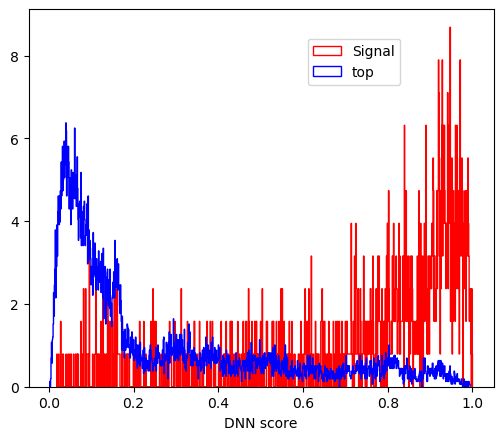

In [36]:
fig = plt.figure(figsize=(6,5), dpi=100)
_ = plt.hist(y_pred[y_test_ROC==1], bins=bins, lw = 1, histtype="step", label="Signal", color='red', density=True)
_ = plt.hist(y_pred[y_test_ROC==0], bins=bins, lw = 1, histtype="step", label="top", color='blue', density=True)
plt.legend(loc=(0.6,0.8), fontsize=10)
plt.xlabel("DNN score", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

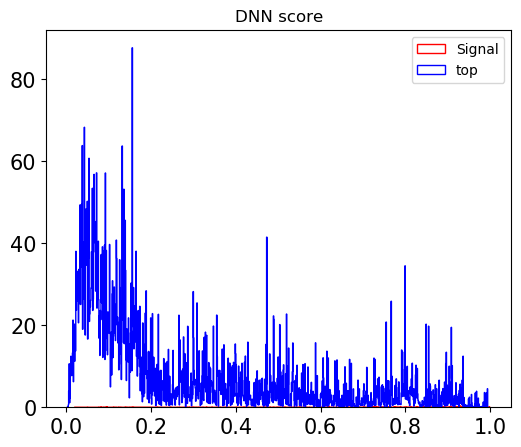

In [37]:
fig = plt.figure(figsize=(6,5), dpi=100)
n_sig, b, _ = plt.hist(y_pred[y_test_ROC==1], bins=bins, histtype="step", weights=Wnn_test_ROC[y_test_ROC==1], label="Signal", color='red')
n_bkg, b, _ = plt.hist(y_pred[y_test_ROC==0], bins=bins, histtype="step", weights=Wnn_test_ROC[y_test_ROC==0], label="top", color='blue')
plt.legend()
plt.title("DNN score")
plt.show()

In [38]:
effS = np.array([])
effB = np.array([])

for i in range(len(n_sig)):
    i = i+1
    S = sum(n_sig[-i:len(n_sig)])
    effS = np.append(effS, S/sum(n_sig))
    
for j in range(len(n_bkg)):
    j = j+1
    B = sum(n_bkg[-j:len(n_bkg)])
    effB = np.append(effB, B/sum(n_bkg))

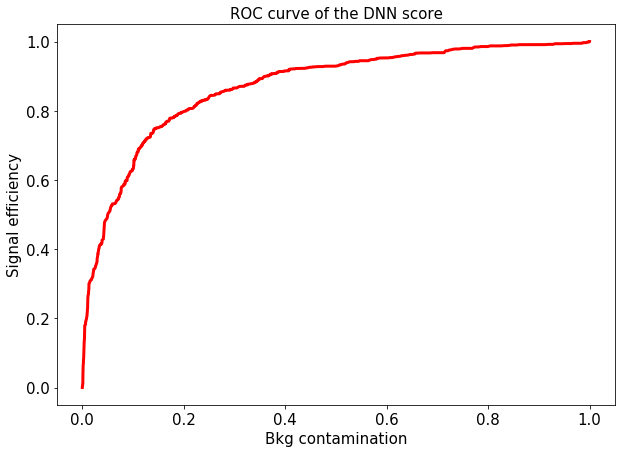

In [39]:
plt.figure(figsize=(10,7))
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel("Bkg contamination", fontsize=15)
plt.ylabel("Signal efficiency", fontsize=15)

plt.title("ROC curve of the DNN score", fontsize=15)
plt.plot(effB,effS,linewidth=3, color="red")
plt.show()

In [40]:
B = effB.tolist()
B.insert(0,0)

In [41]:
S = effS.tolist()
S.insert(0,0)

In [42]:
print(B)
print(S)

[0, 0.0005815078837833237, 0.0006218285580191445, 0.0006357332660716725, 0.0010843892628870653, 0.0010843892628870653, 0.0011077659304378838, 0.0011077659304378838, 0.0015710412862352853, 0.0015710412862352853, 0.0015717440637030343, 0.0017348845819681246, 0.0017552171282771078, 0.0017552171282771078, 0.0017552171282771078, 0.0017798582855839855, 0.0017943716088765944, 0.0017943716088765944, 0.0017943716088765944, 0.001803839185897916, 0.001807452433046076, 0.0019084956376358994, 0.0019253051755404576, 0.0022140381301764545, 0.0022328523901476187, 0.0022462534641848114, 0.0022749061535937525, 0.0027781624613936935, 0.002804966615357525, 0.0028138939502921644, 0.0032635088643110928, 0.0033708376078741874, 0.0033916935992606787, 0.0034032071868407648, 0.0034109807040874694, 0.003437005355008891, 0.0034507333368475127, 0.0034808380721265053, 0.0036193137015974974, 0.0040217558740985055, 0.0040463678983499686, 0.004054612468201527, 0.004110792070876013, 0.004182732793919519, 0.004500633358